In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import mynnlib
from mynnlib import *

dataset_dir = "insect-dataset/odonata"

early_regex = r"^.*-(early)$"
unidentified_regex = r"^.*-(spp|genera|genera-spp)$"
early_or_unidentified_regex = r"^.*-(early|spp|genera|genera-spp)$"

# Create Dataset

In [18]:
if os.path.exists(f"{dataset_dir}/data"):
    shutil.rmtree(f"{dataset_dir}/data")
os.makedirs(f"{dataset_dir}/data")

In [19]:
# merge early and imago classes
src_dir = "insect-dataset/src/indianodonata.org"
for class_dir in os.listdir(src_dir):
    if os.listdir(f"{src_dir}/{class_dir}"):
        if class_dir.endswith("-early"):
            if not os.path.exists(f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}"):
                os.makedirs(f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}")
            for file in os.listdir(f"{src_dir}/{class_dir}"):
                shutil.copy2(f"{src_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}/{file}")
        else:
            shutil.copytree(f"{src_dir}/{class_dir}", f"{dataset_dir}/data/{class_dir}")

In [20]:
def copy_data_from(sources, add_early=False):
    class_cnt = 0
    img_cnt = 0
    for more_data_dir in sources:
        for class_dir in os.listdir(f"{dataset_dir}/data"):
            if os.path.exists(f"{more_data_dir}/{class_dir}"):
                # print(f"Copying data for {class_dir}...")
                class_cnt += 1
                for file in os.listdir(f"{more_data_dir}/{class_dir}"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{class_dir}/{file}")
                    img_cnt += 1
            if add_early and os.path.exists(f"{more_data_dir}/{class_dir}-early"):
                # print(f"Copying data for {class_dir}-early...")
                class_cnt += 1
                os.makedirs(f"{dataset_dir}/data/{class_dir}-early/{file}")
                for file in os.listdir(f"{more_data_dir}/{class_dir}-early"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}-early/{file}", f"{dataset_dir}/data/{class_dir}-early/{file}")
                    img_cnt += 1
    print(f"{img_cnt} images added into {class_cnt} classes")

In [21]:
copy_data_from(["insect-dataset/src/inaturalist.org"], add_early=False)

29636 images added into 310 classes


# Create val dataset

In [37]:
if not os.path.exists(f"{dataset_dir}/val"):
    os.makedirs(f"{dataset_dir}/val")

In [38]:
move_src = "data"
move_dst = "val"
val_data_ratio = 0.03
val_data_cnt = 0
for class_dir in os.listdir(f"{dataset_dir}/{move_src}"):
    for file in os.listdir(f"{dataset_dir}/{move_src}/{class_dir}"):
        if random.random() < val_data_ratio:
            if not os.path.exists(f"{dataset_dir}/{move_dst}/{class_dir}"):
                os.makedirs(f"{dataset_dir}/{move_dst}/{class_dir}")
            shutil.move(f"{dataset_dir}/{move_src}/{class_dir}/{file}", f"{dataset_dir}/{move_dst}/{class_dir}/")
            val_data_cnt += 1
print(f"{val_data_cnt} images moved from {move_src} to {move_dst}")

1320 images moved from data to val


# Count

In [39]:
classes = { class_dir: len([ img for img in os.listdir(f"{dataset_dir}/data/{class_dir}") ]) for class_dir in os.listdir(f"{dataset_dir}/data") }
early_classes = { class_name: count for class_name, count in classes.items() if re.match(early_regex, class_name) }
unidentified_classes = { class_name: count for class_name, count in classes.items() if re.match(unidentified_regex, class_name) }
print(f"Total Class count : {len(classes):6} ( Unidentified: {len(unidentified_classes):6} / Early-stage: {len(early_classes):6} / Identified-adult: {len(classes) - len(unidentified_classes) - len(early_classes):6} )")
print(f"Total  Data count : {sum(classes.values()):6} ( Unidentified: {sum(unidentified_classes.values()):6} / Early-stage: {sum(early_classes.values()):6} / Identified-adult: {sum(classes.values()) - sum(unidentified_classes.values()) - sum(early_classes.values()):6} )")

Total Class count :    383 ( Unidentified:     27 / Early-stage:      0 / Identified-adult:    356 )
Total  Data count :  41441 ( Unidentified:    301 / Early-stage:      0 / Identified-adult:  41140 )


In [40]:
img2_class = []
img5_class = []
for class_dir in os.listdir(f"{dataset_dir}/data"):
    if not re.match(early_or_unidentified_regex, class_dir):
        img_cnt = sum([1 for file in os.listdir(f"{dataset_dir}/data/{class_dir}")])
        img2_class += [class_dir] if img_cnt <= 2 else []
        img5_class += [class_dir] if img_cnt <= 5 else []
print(f"{len(img2_class):6} classes with <=2 images")
print(f"{len(img5_class):6} classes with <=5 images")

    14 classes with <=2 images
    40 classes with <=5 images


In [41]:
generas = set()
for class_name in classes:
    generas.add(class_name.split('-')[0])
print(f"Genera count: {len(generas)}")

Genera count: 140


# Train

### Model A (resnet-152)

In [43]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet152", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.odonata.ta.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 2.5581 Acc: 0.4330  | Val Loss: 1.1868 Acc: 0.6773  | Elapsed time: 0:14:31.251410
Epoch    2 /    5  | Train Loss: 0.8947 Acc: 0.7538  | Val Loss: 0.8410 Acc: 0.7629  | Elapsed time: 0:25:23.832051
Epoch    3 /    5  | Train Loss: 0.5001 Acc: 0.8533  | Val Loss: 0.7669 Acc: 0.7902  | Elapsed time: 0:36:18.656653
Phase 2:
Epoch    1 /    5  | Train Loss: 1.5046 Acc: 0.6183  | Val Loss: 0.9196 Acc: 0.7447  | Elapsed time: 0:11:23.290520
Epoch    2 /    5  | Train Loss: 1.2147 Acc: 0.6862  | Val Loss: 0.8751 Acc: 0.7538  | Elapsed time: 0:22:49.529245
Phase 3:
Epoch    1 /    5  | Train Loss: 1.1541 Acc: 0.7002  | Val Loss: 0.7795 Acc: 0.7606  | Elapsed time: 0:11:26.632949
Epoch    2 /    5  | Train Loss: 1.0553 Acc: 0.7221  | Val Loss: 0.7784 Acc: 0.7758  | Elapsed time: 0:22:52.679076
Epoch    3 /    5  | Train Loss: 0.8533 Acc: 0.7774  | Val Loss: 0.6676 Acc: 0.8076  | Elapsed time: 0:34:18.315970
Epoch    4 /    5  | Train Loss: 0.7628 Acc: 

In [44]:
model_data = torch.load(f"{dataset_dir}/checkpoint.odonata.ta.ep060000.pth", weights_only=False)

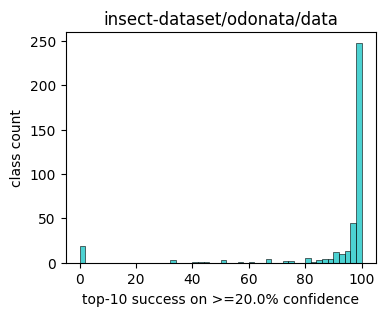

In [45]:
plot_confidence(model_data, f"{dataset_dir}/data", classes, 0.2, k=10)